# Analisis de discriminante y k-vecinos

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [149]:
data = sklearn.datasets.load_iris(as_frame=True);
df = data['data']

df = df.drop(columns=['petal length (cm)', 'petal width (cm)'])
df['species'] = data['target']
# 0: 'setosa', 1: 'versicolor', 2: 'virginica'
df

,sepal length (cm),sepal width (cm),species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,2
146,6.3,2.5,2
147,6.5,3.0,2
148,6.2,3.4,2


Text(0, 0.5, 'Ancho del Sépalo (cm)')

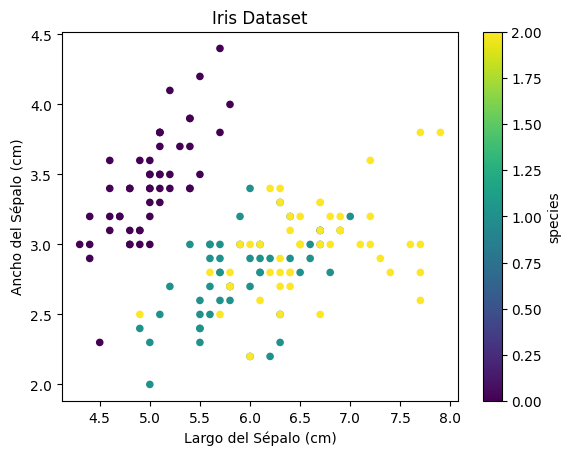

In [150]:
scatter = df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='species', colormap='viridis')
plt.title('Iris Dataset')
plt.xlabel('Largo del Sépalo (cm)')
plt.ylabel('Ancho del Sépalo (cm)')

In [151]:
X_np = df[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
y_np = df['species'].to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, train_size = 0.7, test_size=0.3, random_state=0)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (105, 2)
X_test shape: (45, 2)
y_train shape: (105,)
y_test shape: (45,)


In [152]:
from scipy.special import softmax

class LDA:
    def __init__(self):
        self.clases = None
        self.mu_k = {}
        self.c_k = {}
        self.sigma = None
        self.sigma_inv = None
        self.w = {}
        self.b = {}


    def fit(self, X, y):
        # Convertir y a 1D si es necesario
        self.clases = np.unique(y)
        n_clases = len(self.clases)
        n_muestras = X.shape[0]

        self.D_k = {}
        self.c_k = {}
        self.mu_k = {}
        self.sigma_k = {}
        total_sigma = np.zeros((X.shape[1], X.shape[1]))  # para acumular Σ

        for k in self.clases:
            D_k = X[y == k]
            self.D_k[k] = D_k
            self.c_k[k] = len(D_k) / n_muestras
            self.mu_k[k] = np.mean(D_k, axis=0)
            self.sigma_k[k] = np.cov(D_k.T, bias=False)  # dividimos por |Dk| - 1

            # Acumular para el cálculo de Σ (la covarianza global)
            total_sigma += (len(D_k) - 1) * self.sigma_k[k]

        self.sigma = total_sigma / (n_muestras - n_clases)
        self.sigma_inv = np.linalg.inv(self.sigma)

        # Cálculo de w_y y b_y para cada clase
        self.w = {}
        self.b = {}
        for k in self.clases:
            mu = self.mu_k[k]
            c = self.c_k[k]
            self.w[k] = self.sigma_inv @ mu
            self.b[k] = -0.5 * mu.T @ self.sigma_inv @ mu + np.log(c)

        return self

    def predict_proba(self, X):
        scores = np.array([X @ self.w[k] + self.b[k] for k in self.clases])  # (K, n_muestras)
        probs = softmax(scores, axis=0).T  # Transponemos para (n_muestras, K)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.clases[np.argmax(probs, axis=1)]


In [153]:
clasificador = LDA()
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)

# Imprimir resultados para verificar
print("Predicciones:", y_pred)
print("Precisión:", np.mean(y_pred == y_test))


Predicciones: [1 1 0 2 0 2 0 2 2 1 1 2 1 2 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 2 1 0 1 2 1 0
 1 1 1 2 0 2 0 0]
Precisión: 0.8


/var/folders/0t/trzsj78d28j18x2gyhjtng340000gn/T/ipykernel_1249/2889208269.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


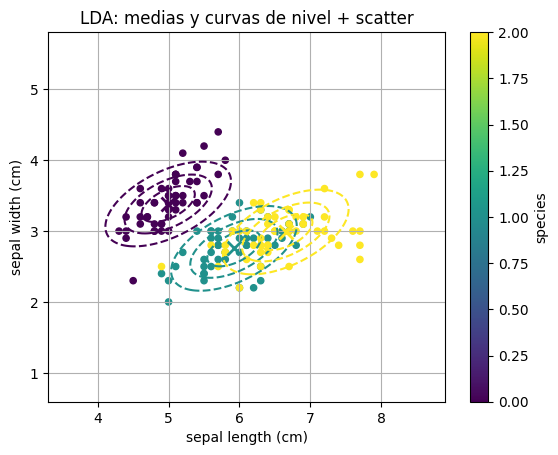

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.cm as cm

def get_viridis_colors(n):
    cmap = cm.get_cmap('viridis')
    return [cmap(i) for i in np.linspace(0, 1, n)]

def plot_lda_contours_with_df(model, X, y, df):
    clases = model.clases
    colores = get_viridis_colors(len(clases))

    fig, ax = plt.subplots()

    # Hacer el scatter con pandas, pero en el mismo ax
    df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='species', colormap='viridis', ax=ax)

    # Crear grilla para curvas de nivel
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    for idx, k in enumerate(clases):
        color = colores[idx % len(colores)]

        # Media
        mu = model.mu_k[k]
        ax.plot(mu[0], mu[1], 'x', color=color, markersize=10, mew=2)

        # Curvas de nivel
        dist = multivariate_normal(mean=mu, cov=model.sigma)
        z = dist.pdf(grid).reshape(xx.shape)
        ax.contour(xx, yy, z, levels=3, colors=color, linestyles='--')

    ax.set_title("LDA: medias y curvas de nivel + scatter")
    ax.axis('equal')
    ax.grid(True)
    plt.show()
plot_lda_contours_with_df(clasificador, X_train, y_train, df)


/var/folders/0t/trzsj78d28j18x2gyhjtng340000gn/T/ipykernel_1249/153134813.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


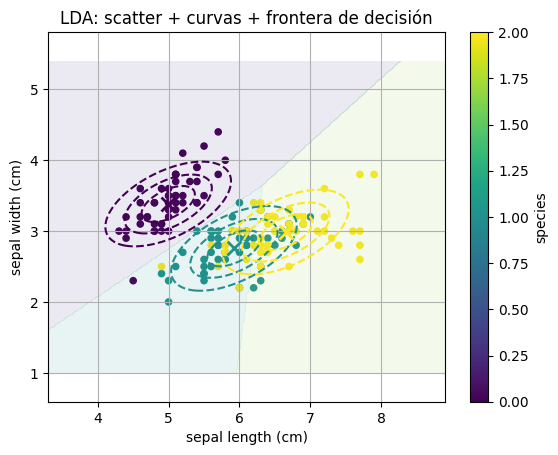

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal

def get_viridis_colors(n):
    cmap = cm.get_cmap('viridis')
    return [cmap(i) for i in np.linspace(0, 1, n)]

def plot_lda_full(model, X, y, df, feature_x, feature_y):
    clases = model.clases
    colores = get_viridis_colors(len(clases))

    fig, ax = plt.subplots()

    # Scatter con pandas en el mismo ax
    df.plot.scatter(x=feature_x, y=feature_y, c='species', colormap='viridis', ax=ax)

    # Crear grilla para curvas de nivel y fronteras
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predecir clases para cada punto de la grilla
    y_pred = model.predict(grid)
    Z = y_pred.reshape(xx.shape)

    # Dibujar fronteras de decisión (con colores suaves)
    ax.contourf(xx, yy, Z, levels=len(clases)-1, alpha=0.1, cmap='viridis')

    # Curvas de nivel de cada clase
    for idx, k in enumerate(clases):
        mu = model.mu_k[k]
        ax.plot(mu[0], mu[1], 'x', color=colores[idx], markersize=10, mew=2)

        dist = multivariate_normal(mean=mu, cov=model.sigma)
        z = dist.pdf(grid).reshape(xx.shape)
        ax.contour(xx, yy, z, levels=3, colors=[colores[idx]], linestyles='--')

    ax.set_title("LDA: scatter + curvas + frontera de decisión")
    ax.axis('equal')
    ax.grid(True)
    plt.show()
plot_lda_full(clasificador, X_train, y_train, df, 'sepal length (cm)', 'sepal width (cm)')


In [156]:
def generar_muestras_sinteticas(model, n=30, random_state=None):
    np.random.seed(random_state)
    
    clases = list(model.clases)
    probabilidades = [model.c_k[k] for k in clases]

    # Elegimos clases según las probabilidades c_k
    clases_sinteticas = np.random.choice(clases, size=n, p=probabilidades)

    # Generamos las muestras
    X_sintetico = np.array([
        np.random.multivariate_normal(mean=model.mu_k[k], cov=model.sigma)
        for k in clases_sinteticas
    ])

    return X_sintetico, clases_sinteticas


/var/folders/0t/trzsj78d28j18x2gyhjtng340000gn/T/ipykernel_1249/153134813.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


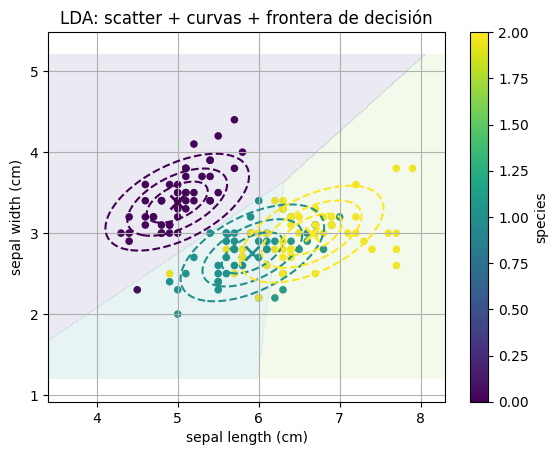

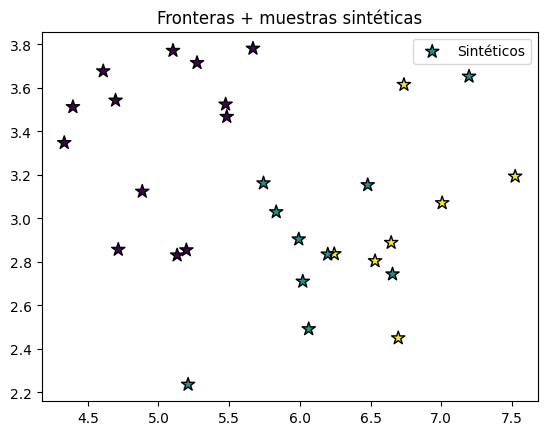

In [159]:
# Generamos las muestras
X_sintetico, y_sintetico = generar_muestras_sinteticas(model=clasificador, n=30, random_state=42)

# Graficamos junto a los datos verdaderos y las fronteras
plot_lda_full(clasificador, X_test, y_test, df=df, feature_x="sepal length (cm)", feature_y="sepal width (cm)")

fig, ax = plt.subplots()
# Scatter con pandas en el mismo ax
x_min, x_max = X_sintetico[:, 0].min() - 1, X_sintetico[:, 0].max() + 1
plt.scatter(X_sintetico[:, 0], X_sintetico[:, 1], c=y_sintetico, cmap='viridis', marker='*', s=100, edgecolors='k', label='Sintéticos')
plt.legend()
plt.title("Fronteras + muestras sintéticas")
plt.show()